In [1]:
import os
import glob
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import ramanspy as rp

## Methods

In [2]:
def load_data(dataset_folder):
    """
    A function that loads a dataset stored in a folder.


    Parameters
    ----------
    dataset_folder: str
        The path to the dataset.

    Returns
    -------
    datasets: np.ndarray or list[np.ndarray]
        A list of mixed images.
    spectral_axis: np.ndarray
        The spectral axis in wavenumbers (cm^-1).
    """
    with open(os.path.join(dataset_folder, 'spectral_axis.pkl'), 'rb') as f:
        spectral_axis = pickle.load(f)

    files = [f.split('/')[-1] for f in glob.glob(os.path.join(dataset_folder, '*.pkl'))]

    dataset_files = [d for d in files if
                     d.split('.')[0] not in ['gt_abundance_image', 'gt_endmembers', 'spectral_axis', 'parameters']]

    datasets = []
    for dataset_file in dataset_files:
        with open(os.path.join(dataset_folder, dataset_file), 'rb') as f:
            mixed_image = pickle.load(f)
            datasets.append(mixed_image)

    if len(datasets) == 1:
        return datasets[0], spectral_axis

    return datasets, spectral_axis


In [3]:
def _snr(spectrum_array):
    """
    Calculate signal-to-noise ratio as mean over standard deviation.


    Parameters
    ----------
    spectrum_array: array
        The spectrum whose SNR to calculate.
    
    
    Reference
    ----------
    McCreery, R.L. (2000). Signal-to-Noise in Raman Spectroscopy. In Raman Spectroscopy for Chemical Analysis (eds J.D. Winefordner and R.L. McCreery). https://doi.org/10.1002/0471721646.ch4
    """
    # Calculate the mean and standard deviation for the given spectrum
    mean_intensity = np.mean(spectrum_array)
    std_deviation = np.std(spectrum_array)
    
    # Calculate SNR for the given spectrum
    snr = mean_intensity / std_deviation
    
    return snr

In [4]:
def snr(spectra, *, aggregation_func=np.mean):
    """
    A function that calculates the SNR of a spectral dataset.


    Parameters
    ----------
    spectra: ramanspy.SpectralContainer
        The data whose SNR to calculate.
    aggregation_func: func
        A method to use to aggregate the final results. Options may include np.mean, np.median, etc. Default is np.mean.
        
        
    Returns
    -------
    float
        The dataset SNR.
    """
    if isinstance(spectra, rp.Spectrum):
        return _snr(spectra.spectral_data)
    
    else:
        snrs = [_snr(spectrum.spectral_data) for spectrum in spectra.flat]
        mean_snr = aggregation_func(snrs)

        return mean_snr

In [5]:
def random_sample(dataset, sample_size, *, seed=42):
    """
    A function that returns a random sample of spectra from a spectral dataset.


    Parameters
    ----------
    dataset: ramanspy.SpectralContainer
        The dataset to sample from.
    sample_size: int
        The number of spectra to sample.
    seed: int
        The random seed to use. Default is 42.

    Returns
    -------
    list[ramanspy.Spectrum]
        A list of spectra sampled from the dataset.
    list[int]
        The indices of the selected spectra sampled from the dataset.
    """    
    shape = dataset.shape
    
    flat_dataset = dataset.flat
    N = flat_dataset.shape[-1]
    
    if sample_size > N:
        raise ValueError("Sample size cannot be larger than the dataset size")
    
    if seed is not None:
        random.seed(seed)
        
    sampled_indices_flat = random.sample(np.arange(N).tolist(), sample_size)
    
    sampled_spectra = [flat_dataset[i] for i in sampled_indices_flat]
    
    sampled_indices = [np.unravel_index(idx, shape) for idx in sampled_indices_flat]
    
    return sampled_spectra, sampled_indices

In [6]:
def dataset_overview(dataset, n_samples=4, *, color=None, save_to=None):
    if save_to is not None:
        os.makedirs(save_to, exist_ok=True)    
    
    # Calculate mean SNR for data
    mean_snr = snr(dataset)
    print(f'Mean SNR:', mean_snr)
        
    # Histogram for entire dataset
    plt.figure(figsize=(8, 2))
    plt.hist(dataset.spectral_data.flatten(), bins=50, color=color)
    plt.xlim(-1, 1)
    plt.xlabel('Normalized intensity')
    plt.ylabel('Counts')
    
    if save_to is not None:
        plt.savefig(f'{save_to}/dataset_histogram.png', dpi=600)
    
    plt.show()
    
    # Randomly sample spectra from dataset
    sampled_spectra, sampled_indices = random_sample(dataset, n_samples)
        
    # Plot sampled spectra    
    fig_sp, axs_sp = plt.subplots(n_samples, 1, figsize=(4, 6), sharex=True, sharey=True)    
    for i, (spectrum, sampled_index) in enumerate(zip(sampled_spectra, sampled_indices)):
        print(f'Spectrum sampled: {sampled_index} with SNR of {snr(spectrum)}')
        
        axs_sp[i].plot(spectrum.spectral_axis, spectrum.spectral_data, color=color)
        axs_sp[i].set_ylabel('Intensity (a.u.)')
    
        if i == len(sampled_spectra) - 1:
            axs_sp[i].set_xlabel('Raman Shift (cm$^{{{-1}}}$)')
    
    if save_to is not None:
        fig_sp.savefig(f'{save_to}/spectra.png', dpi=600)
    
    plt.show()
    
    # Plot histograms of sampled spectra   
    fig_h, axs_h = plt.subplots(n_samples, 1, figsize=(4, 6), sharex=True, sharey=True)
    for i, (spectrum, sampled_index) in enumerate(zip(sampled_spectra, sampled_indices)):
        axs_h[i].hist(spectrum.spectral_data, bins=50, color=color)
        axs_h[i].set_xlim(-1, 1)
        axs_h[i].set_ylabel('Counts')
        
        if i == len(sampled_spectra) - 1:
            axs_h[i].set_xlabel('Normalized intensity')
    
    if save_to is not None:
        fig_h.savefig(f'{save_to}/histograms.png', dpi=600)

    plt.show()

## Sugar data

#### Load data

In [7]:
data_folder = '../Figure 4/raw datasets'

In [8]:
datasets = sorted(glob.glob(os.path.join(data_folder, '*')))
datasets

['../Figure 4/raw datasets/High SNR',
 '../Figure 4/raw datasets/High SNR (no refs)',
 '../Figure 4/raw datasets/Low SNR',
 '../Figure 4/raw datasets/Low SNR (no refs)']

In [9]:
datasets = [d for d in datasets if 'no refs' not in d]
datasets

['../Figure 4/raw datasets/High SNR', '../Figure 4/raw datasets/Low SNR']

In [10]:
sugar_datasets = {}
for dataset_file in datasets:
    mixed_image, spectral_axis = load_data(dataset_file)

    rp_mixed_image = rp.SpectralImage(mixed_image, spectral_axis)
    
    sugar_datasets[dataset_file.split('/')[-1]] = rp_mixed_image

In [11]:
for name, dataset in sugar_datasets.items():
    print(f'Number of spectra in {name}:', np.prod(dataset.shape))

Number of spectra in High SNR: 1960
Number of spectra in Low SNR: 7840


#### Preprocess data

In [12]:
preprocesser = rp.preprocessing.Pipeline([
    rp.preprocessing.misc.Cropper(region=(400, 1800)),
    rp.preprocessing.baseline.ASPLS(),
    rp.preprocessing.normalise.MaxIntensity(pixelwise=True)
])

preprocessed_sugar_datasets = {name: preprocesser.apply(dataset) for name, dataset in sugar_datasets.items()}

#### Calculate SNR

########################################
High SNR
########################################

Mean SNR: 0.6632556089858375


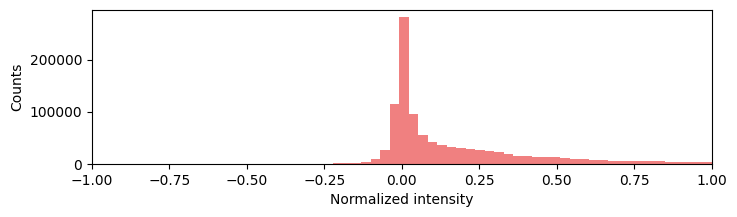

Spectrum sampled: (1309,) with SNR of 0.48592015856252213
Spectrum sampled: (228,) with SNR of 0.7474025893842917
Spectrum sampled: (51,) with SNR of 0.647459161041578
Spectrum sampled: (1518,) with SNR of 0.6304227163597335


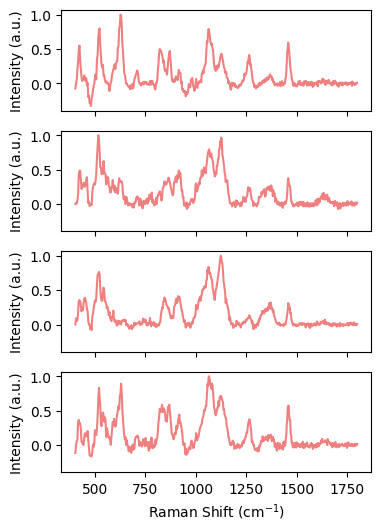

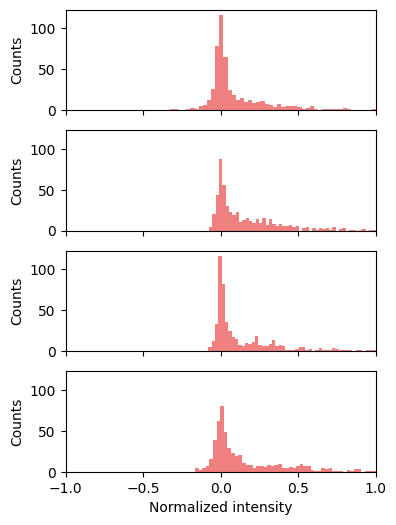

########################################
Low SNR
########################################

Mean SNR: 0.5371497431583359


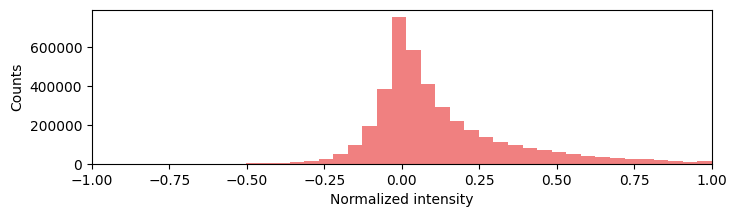

Spectrum sampled: (5238,) with SNR of 0.387421572200451
Spectrum sampled: (912,) with SNR of 0.381448982496407
Spectrum sampled: (204,) with SNR of 0.539178833580687
Spectrum sampled: (6074,) with SNR of 0.7070884577182344


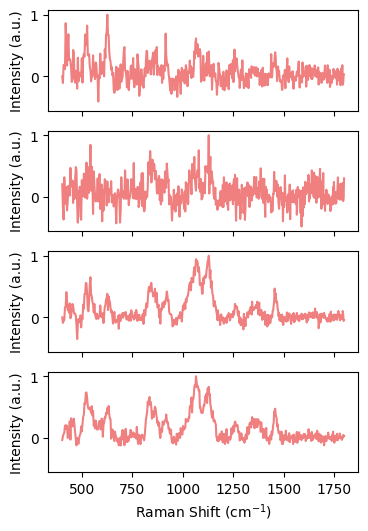

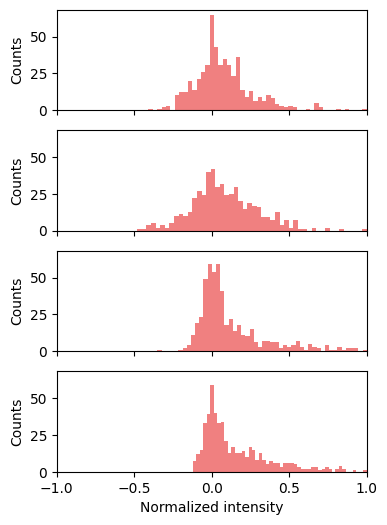

In [13]:
for name, preprocessed_dataset in preprocessed_sugar_datasets.items():    
    print('########################################')
    print(name)
    print('########################################')
    print()
    
    dataset_overview(preprocessed_dataset, save_to=f'Sugar/{name}', color='lightcoral')

## Cell data

#### Load data

In [14]:
data_folder = '../Figure 5/raw data'

In [15]:
volume = rp.SpectralVolume.from_image_stack([rp.load.witec(matlab_file) for matlab_file in sorted(glob.glob(f'{data_folder}/*.mat'))])

In [16]:
print('Number of spectra', np.prod(volume.shape))

Number of spectra 16000


#### Preprocess data

In [18]:
preprocesser = rp.preprocessing.Pipeline([
    rp.preprocessing.misc.Cropper(region=(700, 1800)),
    rp.preprocessing.baseline.ASPLS(),
    rp.preprocessing.normalise.MaxIntensity(pixelwise=True),
])

preprocessed_cell_dataset = preprocesser.apply(volume)

#### Calculate SNR

########################################
Cell
########################################

Mean SNR: 0.43100262


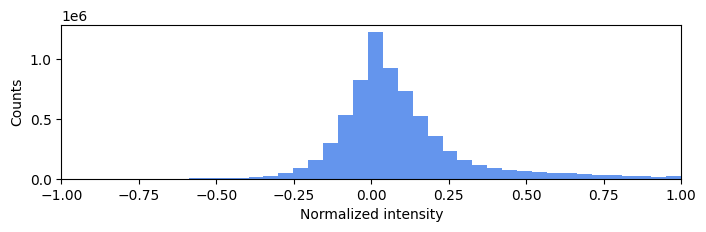

Spectrum sampled: (26, 7, 6) with SNR of 0.5446290373802185
Spectrum sampled: (4, 22, 4) with SNR of 0.3733648359775543
Spectrum sampled: (1, 0, 9) with SNR of 0.34541329741477966
Spectrum sampled: (30, 14, 9) with SNR of 0.33226096630096436


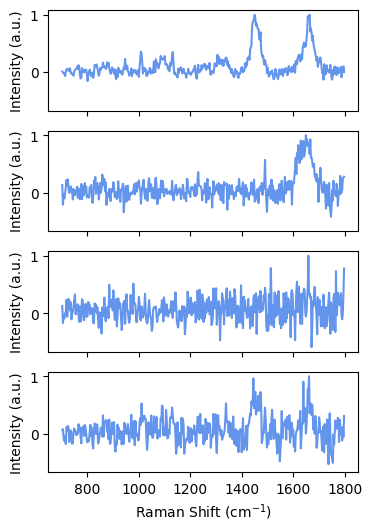

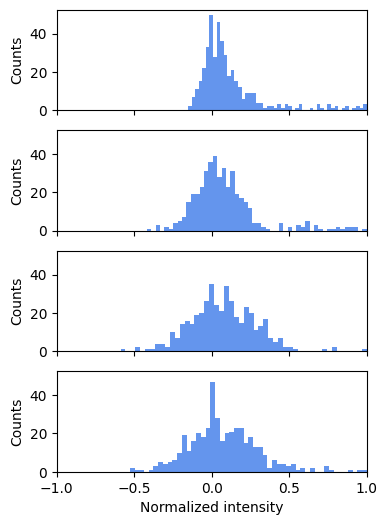

In [19]:
print('########################################')
print('Cell')
print('########################################')
print()
    
dataset_overview(preprocessed_cell_dataset, save_to='Cell', color='cornflowerblue')

## Synthetic data

#### Load data

In [20]:
data_folder = '../Figure 2/Figures 2c/generated data/realistic'

In [21]:
synth_datasets = {}
for scene_folder in glob.glob(os.path.join(data_folder, '*')):
    for repeat_folder in glob.glob(os.path.join(scene_folder, '*')):
        repeat = repeat_folder[-1]
        
        if repeat != '1':
            continue
        
        mixed_image, spectral_axis = load_data(repeat_folder)
        rp_mixed_image = rp.SpectralImage(mixed_image, spectral_axis)

        synth_datasets[repeat_folder.split('/')[-2]] = rp_mixed_image

#### Preprocess data

In [22]:
preprocesser = rp.preprocessing.Pipeline([
    rp.preprocessing.baseline.ASPLS(),
    rp.preprocessing.normalise.MaxIntensity(pixelwise=True)
])

preprocessed_synth_datasets = {name: preprocesser.apply(dataset) for name, dataset in synth_datasets.items()}

#### Calculate SNR

########################################
dirichlet
########################################

Mean SNR: 0.4444818802024892


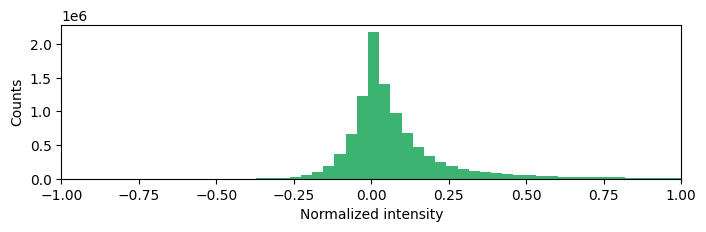

Spectrum sampled: (18, 24) with SNR of 0.40349897812233104
Spectrum sampled: (4, 9) with SNR of 0.42382716227126227
Spectrum sampled: (45, 6) with SNR of 0.44785606336168443
Spectrum sampled: (40, 12) with SNR of 0.5162187656976153


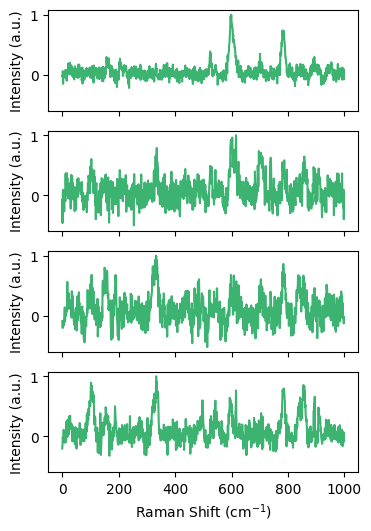

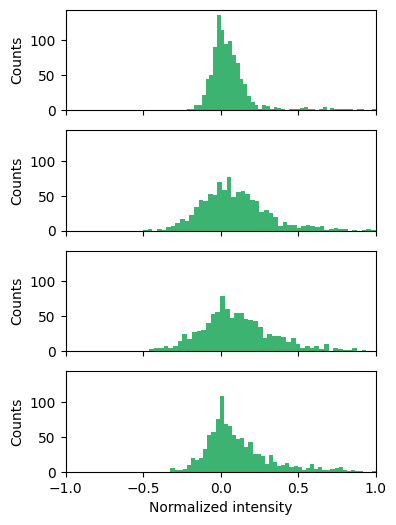

########################################
gaussian
########################################

Mean SNR: 0.4490144053239981


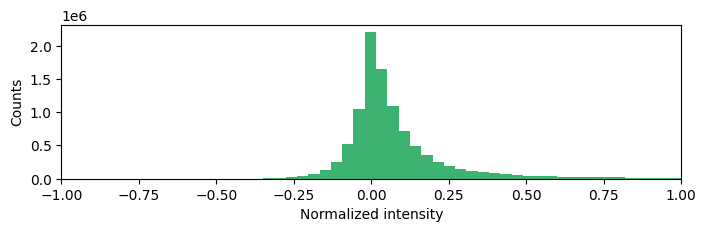

Spectrum sampled: (18, 24) with SNR of 0.508286365933243
Spectrum sampled: (4, 9) with SNR of 0.4618414200336529
Spectrum sampled: (45, 6) with SNR of 0.49503629885660544
Spectrum sampled: (40, 12) with SNR of 0.4774083206026384


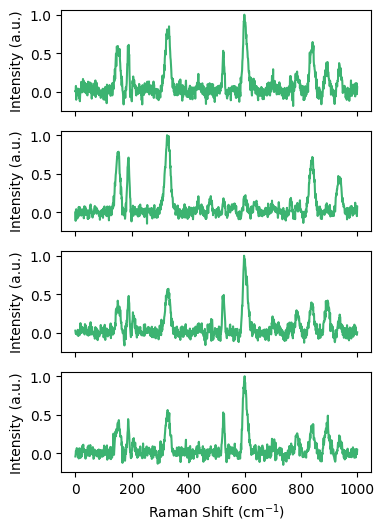

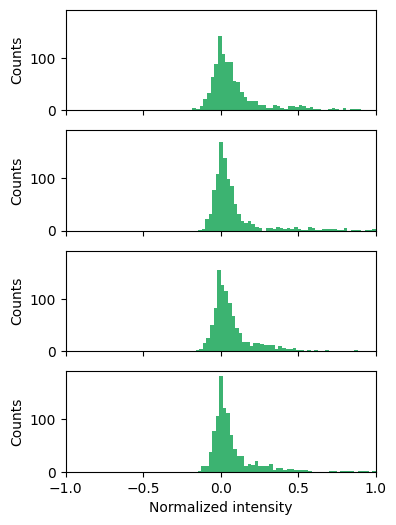

########################################
chessboard
########################################

Mean SNR: 0.4154604276632861


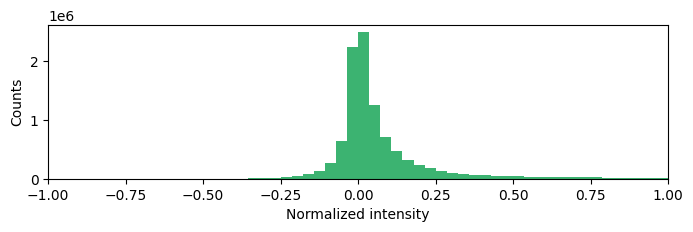

Spectrum sampled: (18, 24) with SNR of 0.40517068000520456
Spectrum sampled: (4, 9) with SNR of 0.46148896997199845
Spectrum sampled: (45, 6) with SNR of 0.48093557274642196
Spectrum sampled: (40, 12) with SNR of 0.4370783253776197


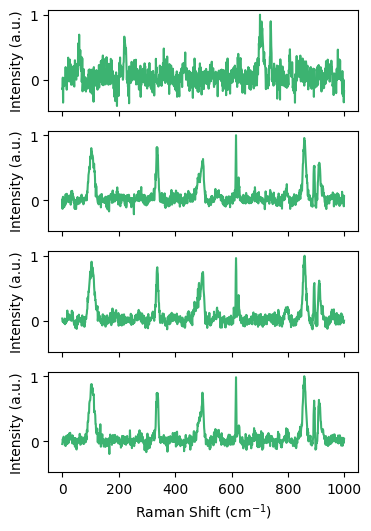

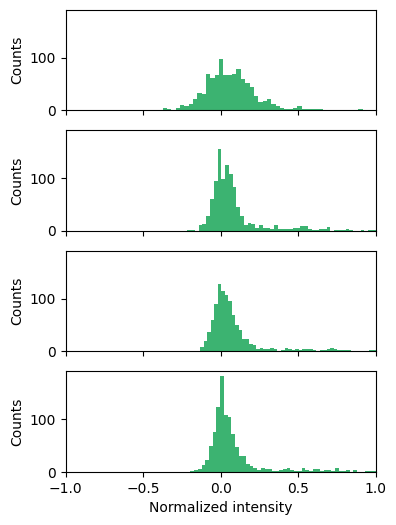

In [23]:
# Define preprocessing pipeline


for name, dataset in synth_datasets.items():
    
    # Preprocess data
    preprocessed_dataset = preprocesser.apply(dataset)
    
    print('########################################')
    print(name)
    print('########################################')
    print()
    
    dataset_overview(preprocessed_dataset, save_to=f'Synthetic/{name}', color='mediumseagreen')

### More synthetic datasets

In [24]:
preprocesser = rp.preprocessing.Pipeline([
    rp.preprocessing.baseline.ASPLS(),
    rp.preprocessing.normalise.MaxIntensity(pixelwise=True)
])

ideal

In [25]:
mixed_image, spectral_axis = load_data('../Figure 2/Figures 2c/generated data/ideal/chessboard/chessboard1')
chessboard1 = rp.SpectralImage(mixed_image, spectral_axis)
preprocessed_chessboard1 = preprocesser.apply(chessboard1)

In [26]:
mixed_image, spectral_axis = load_data('../Figure 2/Figures 2c/generated data/ideal/gaussian/gaussian1')
gaussian1 = rp.SpectralImage(mixed_image, spectral_axis)
preprocessed_gaussian1 = preprocesser.apply(gaussian1)

In [27]:
mixed_image, spectral_axis = load_data('../Figure 2/Figures 2c/generated data/ideal/dirichlet/dirichlet1')
dirichlet1 = rp.SpectralImage(mixed_image, spectral_axis)
preprocessed_dirichlet1 = preprocesser.apply(dirichlet1)

+artifacts

In [28]:
mixed_image, spectral_axis = load_data('../Figure 2/Figures 2c/generated data/artefacts/chessboard/chessboard1')
artefacts_chessboard1 = rp.SpectralImage(mixed_image, spectral_axis)
preprocessed_artefacts_chessboard1 = preprocesser.apply(artefacts_chessboard1)

In [29]:
mixed_image, spectral_axis = load_data('../Figure 2/Figures 2c/generated data/artefacts/gaussian/gaussian1')
artefacts_gaussian1 = rp.SpectralImage(mixed_image, spectral_axis)
preprocessed_artefacts_gaussian1 = preprocesser.apply(artefacts_gaussian1)

In [30]:
mixed_image, spectral_axis = load_data('../Figure 2/Figures 2c/generated data/artefacts/dirichlet/dirichlet1')
artefacts_dirichlet1 = rp.SpectralImage(mixed_image, spectral_axis)
preprocessed_artefacts_dirichlet1 = preprocesser.apply(artefacts_dirichlet1)

+realistic

In [31]:
mixed_image, spectral_axis = load_data('../Figure 2/Figures 2c/generated data/realistic/chessboard/chessboard2')
realistic_chessboard2 = rp.SpectralImage(mixed_image, spectral_axis)
preprocessed_realistic_chessboard2 = preprocesser.apply(realistic_chessboard2)

In [32]:
mixed_image, spectral_axis = load_data('../Figure 2/Figures 2c/generated data/realistic/gaussian/gaussian2')
realistic_gaussian2 = rp.SpectralImage(mixed_image, spectral_axis)
preprocessed_realistic_gaussian2 = preprocesser.apply(realistic_gaussian2)

In [33]:
mixed_image, spectral_axis = load_data('../Figure 2/Figures 2c/generated data/realistic/dirichlet/dirichlet2')
realistic_dirichlet2 = rp.SpectralImage(mixed_image, spectral_axis)
preprocessed_realistic_dirichlet2 = preprocesser.apply(realistic_dirichlet2)

#### Combine all datasets

In [34]:
all_datasets = {
    'Synthetic data (chessboard, ideal, dataset 1)': preprocessed_chessboard1,
    'Synthetic data (gaussian, ideal, dataset 1)': preprocessed_gaussian1,
    'Synthetic data (dirichlet, ideal, dataset 1)': preprocessed_dirichlet1,
    'Synthetic data (chessboard, +artefacts, dataset 1)': preprocessed_artefacts_chessboard1,
    'Synthetic data (gaussian, +artefacts, dataset 1)': preprocessed_artefacts_gaussian1,
    'Synthetic data (dirichlet, +artefacts, dataset 1)': preprocessed_artefacts_dirichlet1,
    'Synthetic data (chessboard, +realistic, dataset 1)': preprocessed_synth_datasets['chessboard'],
    'Synthetic data (gaussian, +realistic, dataset 1)': preprocessed_synth_datasets['gaussian'],
    'Synthetic data (dirichlet, +realistic, dataset 1)': preprocessed_synth_datasets['dirichlet'],
    'Synthetic data (chessboard, +realistic, dataset 2)': preprocessed_realistic_chessboard2,
    'Synthetic data (gaussian, +realistic, dataset 2)': preprocessed_realistic_gaussian2,
    'Synthetic data (dirichlet, +realistic, dataset 2)': preprocessed_realistic_dirichlet2,
    'Sugar data (high snr)': preprocessed_sugar_datasets['High SNR'],
    'Sugar data (low snr)': preprocessed_sugar_datasets['Low SNR'],
    'Cell data': preprocessed_cell_dataset,    
}
all_datasets

{'Synthetic data (chessboard, ideal, dataset 1)': <ramanspy.core.SpectralImage at 0x299860bd0>,
 'Synthetic data (gaussian, ideal, dataset 1)': <ramanspy.core.SpectralImage at 0x29a06e1d0>,
 'Synthetic data (dirichlet, ideal, dataset 1)': <ramanspy.core.SpectralImage at 0x2a297cad0>,
 'Synthetic data (chessboard, +artefacts, dataset 1)': <ramanspy.core.SpectralImage at 0x299d36190>,
 'Synthetic data (gaussian, +artefacts, dataset 1)': <ramanspy.core.SpectralImage at 0x29a05c1d0>,
 'Synthetic data (dirichlet, +artefacts, dataset 1)': <ramanspy.core.SpectralImage at 0x29a06e250>,
 'Synthetic data (chessboard, +realistic, dataset 1)': <ramanspy.core.SpectralImage at 0x2a601f810>,
 'Synthetic data (gaussian, +realistic, dataset 1)': <ramanspy.core.SpectralImage at 0x2a2ad2050>,
 'Synthetic data (dirichlet, +realistic, dataset 1)': <ramanspy.core.SpectralImage at 0x2a5eed850>,
 'Synthetic data (chessboard, +realistic, dataset 2)': <ramanspy.core.SpectralImage at 0x299d71410>,
 'Synthetic da

#### Dataset with Gaussian noise

In [35]:
np.random.seed(42)

mean, std, signal_length = 0, 0.5, 1000
num_signals = 10000

gaussian_signals = np.array([np.random.normal(mean, std, signal_length) for _ in range(num_signals)])

all_datasets['Gaussian noise'] = rp.SpectralImage(gaussian_signals, np.arange(0, signal_length))
all_datasets

{'Synthetic data (chessboard, ideal, dataset 1)': <ramanspy.core.SpectralImage at 0x299860bd0>,
 'Synthetic data (gaussian, ideal, dataset 1)': <ramanspy.core.SpectralImage at 0x29a06e1d0>,
 'Synthetic data (dirichlet, ideal, dataset 1)': <ramanspy.core.SpectralImage at 0x2a297cad0>,
 'Synthetic data (chessboard, +artefacts, dataset 1)': <ramanspy.core.SpectralImage at 0x299d36190>,
 'Synthetic data (gaussian, +artefacts, dataset 1)': <ramanspy.core.SpectralImage at 0x29a05c1d0>,
 'Synthetic data (dirichlet, +artefacts, dataset 1)': <ramanspy.core.SpectralImage at 0x29a06e250>,
 'Synthetic data (chessboard, +realistic, dataset 1)': <ramanspy.core.SpectralImage at 0x2a601f810>,
 'Synthetic data (gaussian, +realistic, dataset 1)': <ramanspy.core.SpectralImage at 0x2a2ad2050>,
 'Synthetic data (dirichlet, +realistic, dataset 1)': <ramanspy.core.SpectralImage at 0x2a5eed850>,
 'Synthetic data (chessboard, +realistic, dataset 2)': <ramanspy.core.SpectralImage at 0x299d71410>,
 'Synthetic da

## Similarity

##### Dataset-wise similarity matrix

In [36]:
from scipy.stats import entropy, wasserstein_distance

In [37]:
def calculate_kl_divergence(p, q):
    p = p + 1e-10  # Add small value to avoid log(0)
    q = q + 1e-10
    return entropy(p, q)

def dataset_to_histogram(dataset, bins=50):
    hist, _ = np.histogram(dataset.spectral_data.flatten(), bins=bins, density=True)

    return hist

In [38]:
histograms_dict = {name: dataset_to_histogram(dataset) for name, dataset in all_datasets.items()}

dataset_names = list(histograms_dict.keys())
histograms = list(histograms_dict.values())

In [39]:
N_d = len(histograms)
similarity_matrix = np.zeros((N_d, N_d))

for i in range(N_d):
    for j in range(N_d):
        sim = calculate_kl_divergence(histograms[i], histograms[j])
        similarity_matrix[i, j] = sim

In [40]:
similarity_matrix_wasserstein = np.zeros((N_d, N_d))

for i in range(N_d):
    for j in range(i, N_d):
        sim = wasserstein_distance(histograms[i], histograms[j])
        similarity_matrix_wasserstein[i, j] = similarity_matrix_wasserstein[j, i] = sim

##### Similarity plots

In [41]:
tick_label_colors = ['mediumseagreen']*12 + ['lightcoral']*2 + ['cornflowerblue']*1 + ['black']*1

In [42]:
import seaborn as sns

def plot_similarity_matrix(similarity_matrix, labels, *, cbar_label, cmap='viridis', save_to=None):
    plt.figure(figsize=(12, 10))
    sns.set(style='whitegrid', context='notebook')
    ax = sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap=cmap, cbar=True,
                     square=True, linewidths=.5, linecolor='gray', annot_kws={"size": 10})
    
    # Customize the axes and labels
    plt.xticks(np.arange(len(similarity_matrix)) + 0.5, labels, rotation=90)
    plt.yticks(np.arange(len(similarity_matrix)) + 0.5, labels, rotation=0)
    
    # Set tick labels color
    for i, tick in enumerate(ax.get_xticklabels()):
        tick.set_color(tick_label_colors[i])
    for i, tick in enumerate(ax.get_yticklabels()):
        tick.set_color(tick_label_colors[i])
    
    cbar = ax.collections[0].colorbar
    cbar.set_label(cbar_label, fontsize=12, labelpad=10)
    
    # Adjust layout for better appearance
    plt.tight_layout()
    
    if save_to is not None:
        plt.savefig(save_to, dpi=600)
    
    # Show the plot
    plt.show()

In [43]:
plot_similarity_matrix(similarity_matrix, dataset_names, cbar_label='KL divergence (Low: Similar, High: Different)', cmap='Reds', save_to='similarity.png')

In [ ]:
plot_similarity_matrix(similarity_matrix_wasserstein, dataset_names, cbar_label='Wasserstein distance (Low: Similar, High: Different)', cmap='Reds', save_to='similarity_wasserstein.png')

##### Spectra-wise similarity matrix

In [45]:
sample_size = 100

spectra = []
dataset_index = []
for name, dataset in all_datasets.items():
    # Randomly sample spectra from dataset
    sampled_spectra, sampled_indices = random_sample(dataset, sample_size)
    
    spectra += sampled_spectra
    dataset_index += [name] * len(sampled_spectra)
    
    
print(len(spectra), len(dataset_index))  

1600 1600


In [46]:
spectral_histograms = [dataset_to_histogram(s) for s in spectra]
len(spectral_histograms)

1600

In [47]:
N = len(spectral_histograms)

similarity_matrix_wasserstein_spectrawise = np.zeros((N, N))

for i in range(N):
    for j in range(i, N):
        sim = wasserstein_distance(spectral_histograms[i], spectral_histograms[j])
        similarity_matrix_wasserstein_spectrawise[i, j] = similarity_matrix_wasserstein_spectrawise[j, i] = sim

##### MDS

In [109]:
from sklearn.manifold import MDS
from matplotlib.cm import get_cmap
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
from scipy.stats import chi2


def calculate_scale_factor(percentage):
    # Convert percentage to proportion
    proportion = percentage / 100.0
    # Calculate the chi-square value for 2 degrees of freedom
    chi2_val = chi2.ppf(proportion, df=2)
    # Calculate the scale factor
    scale_factor = np.sqrt(chi2_val)
    return scale_factor


def darken_color(color, factor=0.7):
    # Darken the color by the given factor
    r, g, b, a = color
    return (r * factor, g * factor, b * factor, a)


def plot_mds(distance_matrix, labels, *, save_to=None, s=10, plot_ellipses=False, percentage=95):
    mds = MDS(dissimilarity='precomputed', random_state=42)
    mds_coords = mds.fit_transform(distance_matrix)
    
    scale_factor = calculate_scale_factor(percentage)
    
    plt.figure(figsize=(16, 8))
    
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    cmap = get_cmap('tab20', len(unique_labels))  # Get a colormap with enough distinct colors
    
    for i, label in enumerate(unique_labels):
        idx = labels == label        
        points = mds_coords[idx]
        plt.scatter(points[:, 0], points[:, 1], label=label, s=s, color=cmap(i), zorder=1)
        
        if plot_ellipses:
            mean = np.mean(points, axis=0)
            cov = np.cov(points, rowvar=False)

            # Calculate eigenvalues and eigenvectors for the covariance matrix
            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]

            # Compute angle for ellipse
            angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

            # Compute width and height of the ellipse
            width, height = 2 * scale_factor * np.sqrt(eigenvalues)

            edgecolor = darken_color(cmap(i), factor=0.9)
            
            # Draw the ellipse
            ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=edgecolor, fc='None', zorder=10)
            plt.gca().add_patch(ellipse)
    
    plt.xlabel('MDS Dimension 1', fontsize=14)
    plt.ylabel('MDS Dimension 2', fontsize=14)
    plt.legend(title="Datasets", fontsize=12)
    plt.grid(True)
    
    # Place the legend outside the plot
    plt.legend(title="Datasets", fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
    
    
    if save_to is not None:
        plt.savefig(save_to, dpi=600)
    
    plt.show()

spectra-level MDS.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/var/folders/pg/fd2gphys32j1fgnzsp5dt6_w0000gn/T/ipykernel_1873/1444129143.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', len(unique_labels))  # Get a colormap with enough distinct colors


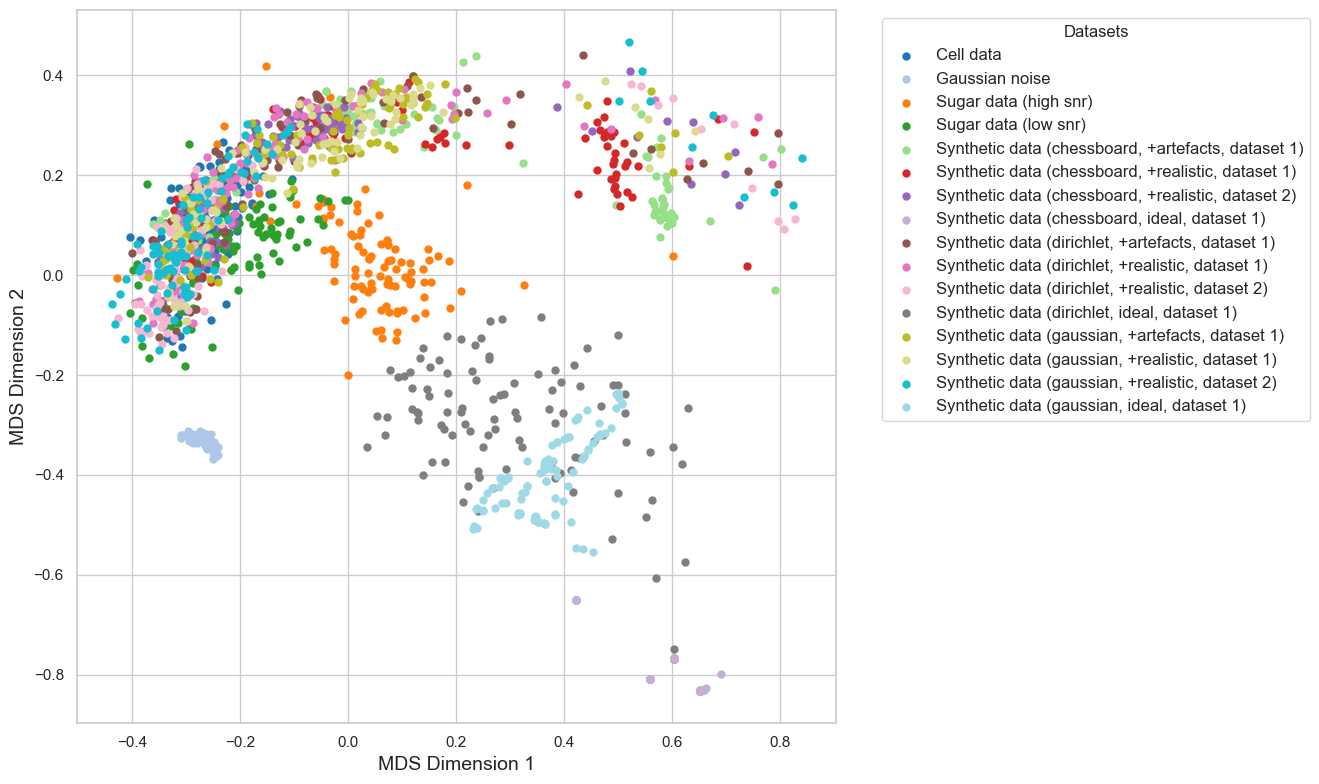

In [49]:
plot_mds(similarity_matrix_wasserstein_spectrawise, dataset_index, save_to='MDS_wasserstein.png')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/var/folders/pg/fd2gphys32j1fgnzsp5dt6_w0000gn/T/ipykernel_1873/1735471189.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', len(unique_labels))  # Get a colormap with enough distinct colors


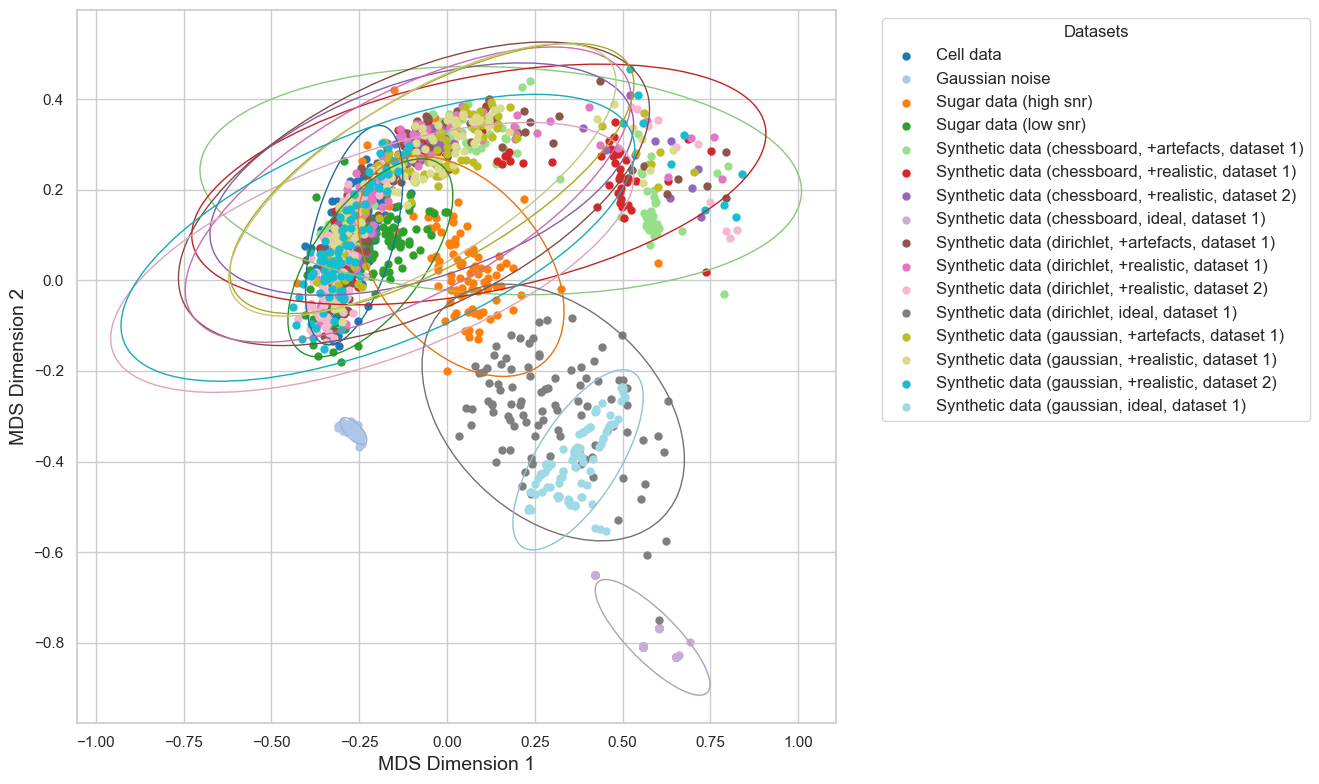

In [110]:
plot_mds(similarity_matrix_wasserstein_spectrawise, dataset_index, s=25, percentage=95, plot_ellipses=True, save_to='MDS_wasserstein_with_ellipses_95_25.png')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/var/folders/pg/fd2gphys32j1fgnzsp5dt6_w0000gn/T/ipykernel_1873/1735471189.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', len(unique_labels))  # Get a colormap with enough distinct colors


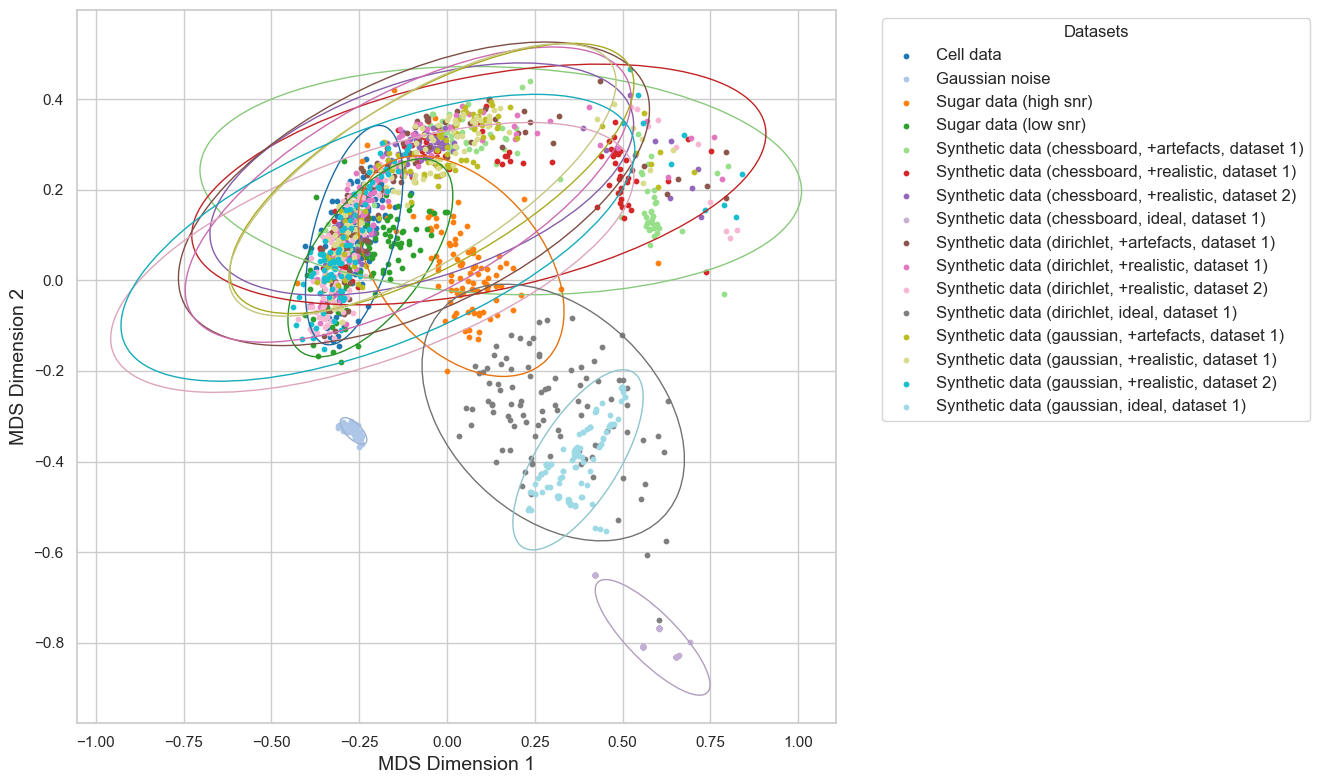

In [111]:
plot_mds(similarity_matrix_wasserstein_spectrawise, dataset_index, s=10, percentage=95, plot_ellipses=True, save_to='MDS_wasserstein_with_ellipses_95_10.png')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/var/folders/pg/fd2gphys32j1fgnzsp5dt6_w0000gn/T/ipykernel_1873/1735471189.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', len(unique_labels))  # Get a colormap with enough distinct colors


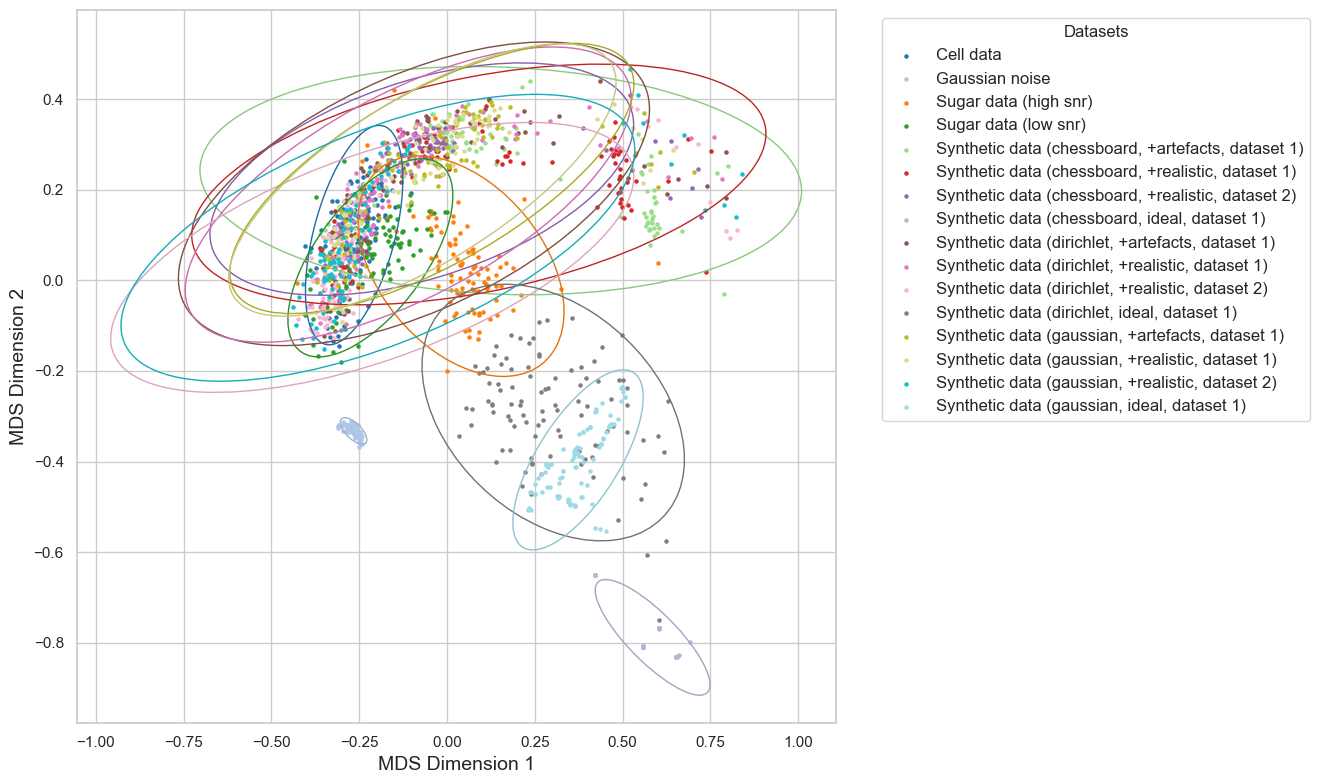

In [112]:
plot_mds(similarity_matrix_wasserstein_spectrawise, dataset_index, s=5, percentage=95, plot_ellipses=True, save_to='MDS_wasserstein_with_ellipses_95_5.png')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/var/folders/pg/fd2gphys32j1fgnzsp5dt6_w0000gn/T/ipykernel_1873/1735471189.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', len(unique_labels))  # Get a colormap with enough distinct colors


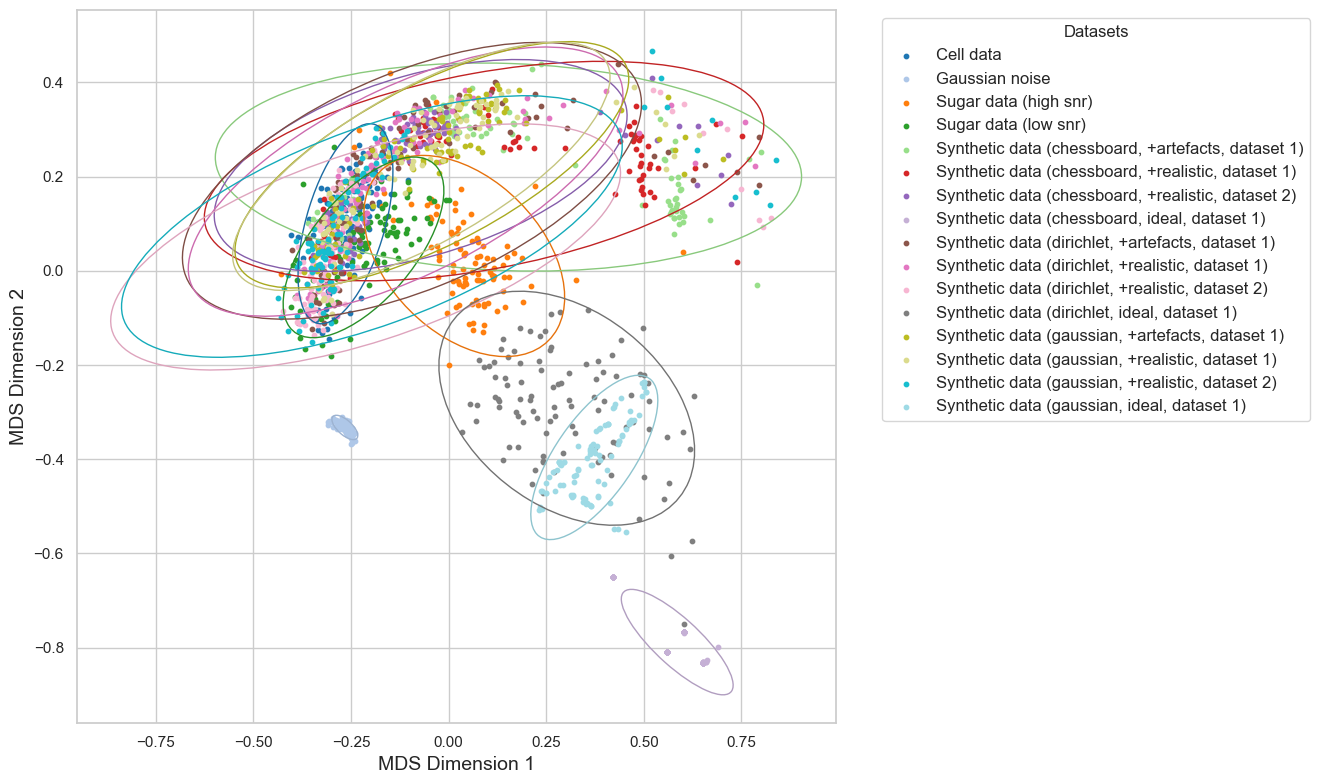

In [113]:
plot_mds(similarity_matrix_wasserstein_spectrawise, dataset_index, s=10, percentage=90, plot_ellipses=True, save_to='MDS_wasserstein_with_ellipses_90_10.png')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/var/folders/pg/fd2gphys32j1fgnzsp5dt6_w0000gn/T/ipykernel_1873/1735471189.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', len(unique_labels))  # Get a colormap with enough distinct colors


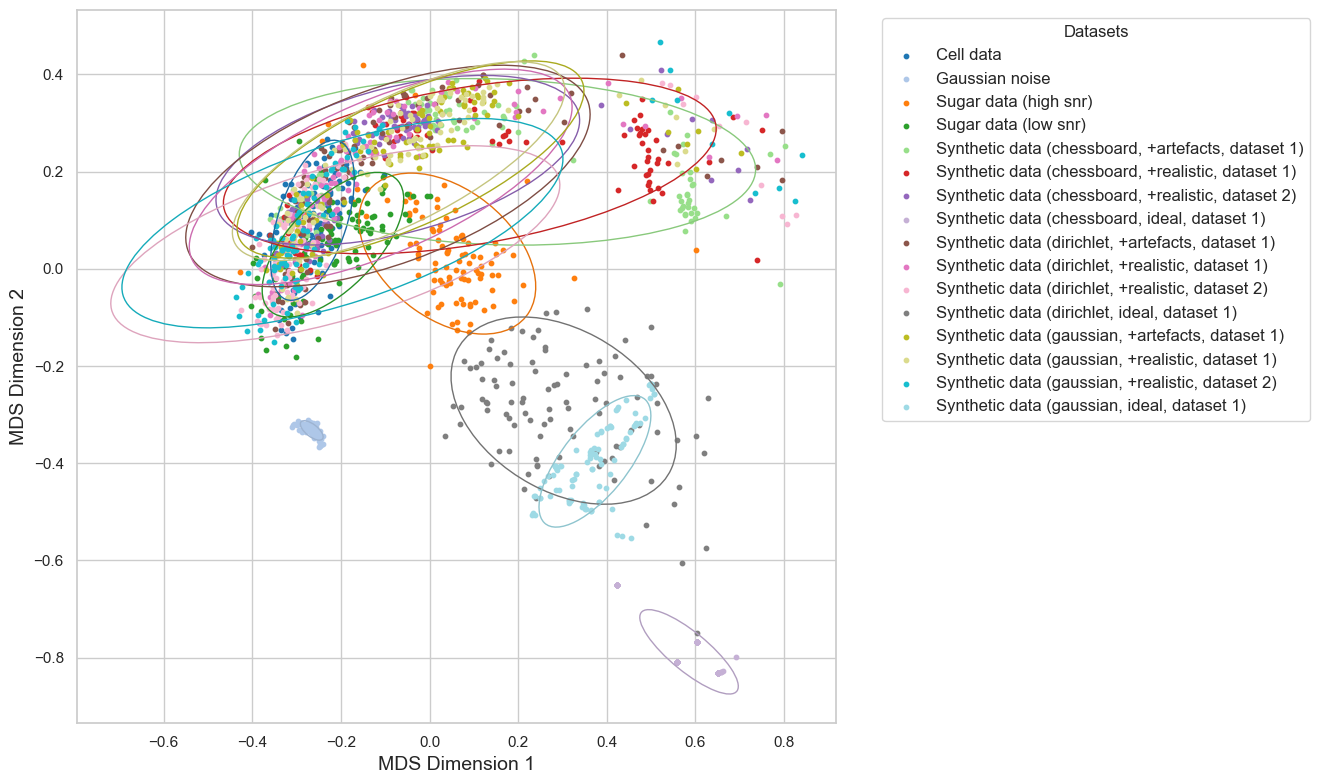

In [114]:
plot_mds(similarity_matrix_wasserstein_spectrawise, dataset_index, s=10, percentage=75, plot_ellipses=True, save_to='MDS_wasserstein_with_ellipses_75_10.png')

In [117]:
plot_mds(similarity_matrix_wasserstein_spectrawise, dataset_index, s=10, percentage=50, plot_ellipses=True, save_to='MDS_wasserstein_with_ellipses_50_10.png')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/var/folders/pg/fd2gphys32j1fgnzsp5dt6_w0000gn/T/ipykernel_1873/1735471189.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', len(unique_labels))  # Get a colormap with enough distinct colors


Dataset-level MDS.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/var/folders/pg/fd2gphys32j1fgnzsp5dt6_w0000gn/T/ipykernel_1873/1444129143.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', len(unique_labels))  # Get a colormap with enough distinct colors


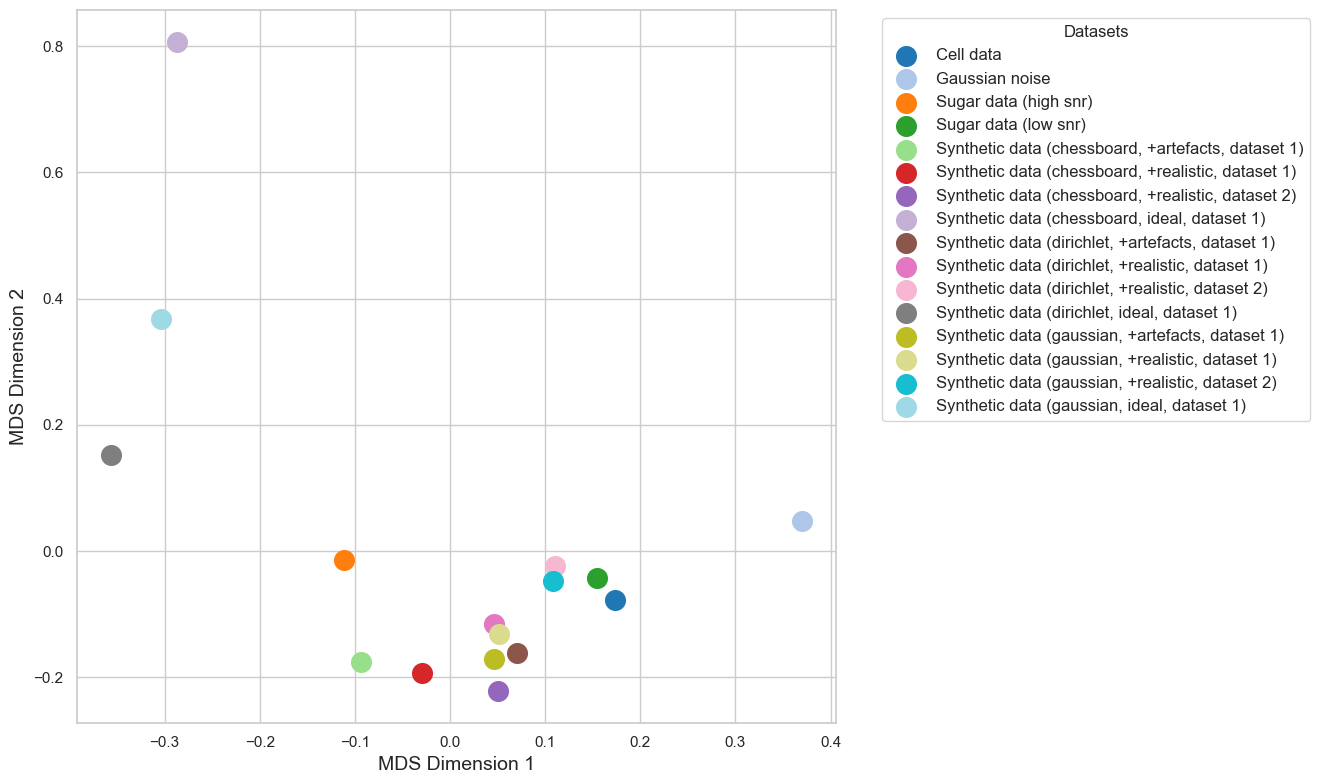

In [50]:
plot_mds(similarity_matrix_wasserstein, dataset_names, s=200, save_to='MDS_wasserstein_datasets.png')